In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

In [2]:
video_folder = "/home/persie/Videos/mokap/"
session_id = os.listdir(video_folder)
video_file = []
for folder in session_id:
    files = os.listdir(os.path.join(video_folder, folder))
    for file in files:
        video_file.append(os.path.join(video_folder, folder, file))


In [3]:
cap = cv2.VideoCapture(video_file[33])
cap.set(cv2.CAP_PROP_POS_FRAMES, 134)
ret, frame = cap.read()
clear_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [4]:
def draw_circle(event,x,y,flags,param):
    #Because of the use of global variables, they must be defined before using them, outside of any functions
    global radius, text_image, mask  
    if flags == cv2.EVENT_FLAG_SHIFTKEY:
            cv2.circle(mask,(x,y),radius,(0,0,0),-1)    
    if flags == cv2.EVENT_FLAG_LBUTTON:
        cv2.circle(mask,(x,y),radius,(255,255,255),-1)      
        
    text_image = cv2.rectangle(text_image, (0, 70), (35, 40), (255, 255, 255), -1)    
    text_image = cv2.putText(text_image, str(radius), (0, 65), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(0, 0, 255), thickness=2)         
        

In [5]:
#Select frame with object in
cap = cv2.VideoCapture(video_file[33])
cap.set(cv2.CAP_PROP_POS_FRAMES, 1507)
ret, frame = cap.read()
object_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [19]:
# Run the mask creation code
text_image = object_frame
mask = np.zeros_like(object_frame, np.uint8)
# Set the initial circle radius
radius = 50
line_1 = "Click with the left mouse button to add, double click to remove"
line_2 = "Up = radius + 5,"
line_3 = "Down = radius - 5"
text_image = cv2.putText(text_image, line_1, (10, 10), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 255, 0), thickness=2)  
text_image = cv2.putText(text_image, line_2, (10, 22), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 255, 0), thickness=2)  
text_image = cv2.putText(text_image, line_3, (10, 34), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 255, 0), thickness=2)  
combined_image = cv2.bitwise_or(text_image, mask)
cv2.namedWindow('Mask On Frame')
cv2.imshow('Mask On Frame', combined_image)
cv2.setMouseCallback('Mask On Frame',draw_circle)


while(1):
    combined_image = cv2.bitwise_or(text_image, mask)
    cv2.imshow('Mask On Frame',combined_image)
    cv2.imshow('Mask',mask)
    k = cv2.waitKey(20) & 0xFF
    if k == ord("q"):
        break
    if k == 82:
        #upkey
        radius = radius + 5
    if k == 84:
        #downkey
        radius = radius - 5

cap.release()
cv2.destroyAllWindows()

In [20]:
#save the mask separately
object_mask = mask

In [8]:
# Get another test frame
cap = cv2.VideoCapture(video_file[33])
cap.set(cv2.CAP_PROP_POS_FRAMES, 2934)
ret, frame = cap.read()
img_scene = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [22]:
#Select the image pixels and the mask and just check that it is alright
img_object = cv2.bitwise_and(object_frame, object_mask)

if img_object is None or img_scene is None:
    print('Could not open or find the images!')
    exit(0)

cv2.imshow("Masked Image", img_object)
cv2.imshow("Comparison Scene", img_scene)
while 1:
    if cv2.waitKey(20) & 0xFF == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()



In [10]:
#-- Step 1: Detect the keypoints using SIFT Detector, compute the descriptors
detector = cv2.SIFT_create()
keypoints_obj, descriptors_obj = detector.detectAndCompute(img_object, None)
keypoints_scene, descriptors_scene = detector.detectAndCompute(img_scene, None)
norm = cv2.NORM_L2
 

In [11]:
#-- Step 1: Detect the keypoints using ORB Detector, compute the descriptors
detector = cv2.ORB_create(edgeThreshold=5, patchSize=10, nlevels=10, fastThreshold=15, scaleFactor=1.4, WTA_K=2,scoreType=cv2.ORB_HARRIS_SCORE, firstLevel=2, nfeatures=500)
keypoints_obj, descriptors_obj = detector.detectAndCompute(object_frame, mask=object_mask)
keypoints_scene, descriptors_scene = detector.detectAndCompute(img_scene, None)
norm = cv2.NORM_HAMMING
 

In [12]:
#-- Step 2: Matching descriptor vectors with a FLANN based matcher
# Since SURF is a floating-point descriptor NORM_L2 is used
#matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
FLANN_INDEX_KDTREE = 1
FLANN_INDEX_LSH=6
if norm == cv2.NORM_L2:
    flann_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
else:
    flann_params= dict(algorithm = FLANN_INDEX_LSH,
                       table_number = 6, # 12
                       key_size = 12,     # 20
                       multi_probe_level = 1) #2


search_params = dict(checks = 50)
matcher = cv2.FlannBasedMatcher(flann_params, search_params)
knn_matches = matcher.knnMatch(descriptors_obj, descriptors_scene, 2)


#-- Filter matches using the Lowe's ratio test
ratio_thresh = 0.7
good_matches = []
for m,n in knn_matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)
 
#-- Draw matches
img_matches = np.empty((max(object_frame.shape[0], img_scene.shape[0]), object_frame.shape[1]+img_scene.shape[1], 3), dtype=np.uint8)
cv2.drawMatches(object_frame, keypoints_obj, img_scene, keypoints_scene, good_matches, img_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


array([[[131, 131, 131],
        [131, 131, 131],
        [131, 131, 131],
        ...,
        [138, 138, 138],
        [137, 137, 137],
        [137, 137, 137]],

       [[131, 131, 131],
        [131, 131, 131],
        [131, 131, 131],
        ...,
        [137, 137, 137],
        [137, 137, 137],
        [137, 137, 137]],

       [[131, 131, 131],
        [131, 131, 131],
        [131, 131, 131],
        ...,
        [137, 137, 137],
        [137, 137, 137],
        [137, 137, 137]],

       ...,

       [[132, 132, 132],
        [132, 132, 132],
        [132, 132, 132],
        ...,
        [129, 129, 129],
        [129, 129, 129],
        [129, 129, 129]],

       [[132, 132, 132],
        [132, 132, 132],
        [132, 132, 132],
        ...,
        [129, 129, 129],
        [129, 129, 129],
        [129, 129, 129]],

       [[132, 132, 132],
        [132, 132, 132],
        [132, 132, 132],
        ...,
        [128, 128, 128],
        [129, 129, 129],
        [129, 129, 129]]

In [13]:
MIN_MATCH_COUNT = 7
if len(good_matches)>MIN_MATCH_COUNT:
    src_pts = np.float32([ keypoints_obj[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints_scene[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = object_frame.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img_scene,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT) )
    matchesMask = None

In [60]:
import numpy as np
import cv2 as cv

img = img_scene

cv.namedWindow('ORB', cv.WINDOW_NORMAL)

def f(x):
    return

# Initiate ORB detector
cv.createTrackbar('Edge Threshold', 'ORB', 15, 50, f)
cv.createTrackbar('Patch Size', 'ORB', 31, 30, f)
cv.createTrackbar('N Levels', 'ORB', 8, 30, f)
cv.createTrackbar('Fast Threshold', 'ORB', 20, 50, f)
cv.createTrackbar('Scale Factor', 'ORB', 12, 25, f)
cv.createTrackbar('WTA K', 'ORB', 2, 4, f)
cv.createTrackbar('First Level', 'ORB', 0, 20, f)
cv.createTrackbar('N Features', 'ORB', 500, 1000, f)

while True:
    edge_threshold = cv.getTrackbarPos('Edge Threshold', 'ORB')
    patch_size = cv.getTrackbarPos('Patch Size', 'ORB')
    n_levels = cv.getTrackbarPos('N Levels', 'ORB')
    fast_threshold = cv.getTrackbarPos('Fast Threshold', 'ORB')
    scale_factor = cv.getTrackbarPos('Scale Factor', 'ORB') / 10
    wta_k = cv.getTrackbarPos('WTA K', 'ORB')
    first_level = cv.getTrackbarPos('First Level', 'ORB')
    n_features = cv.getTrackbarPos('N Features', 'ORB')

    if wta_k < 2:
        wta_k = 2

    if patch_size < 2:
        patch_size = 2

    if n_levels < 1:
        n_levels = 1

    if scale_factor < 1:
        scale_factor = 1

    orb = cv.ORB_create(edgeThreshold=edge_threshold, patchSize=patch_size, nlevels=n_levels, fastThreshold=fast_threshold, scaleFactor=scale_factor, WTA_K=wta_k,scoreType=cv.ORB_HARRIS_SCORE, firstLevel=first_level, nfeatures=n_features)

    # find the keypoints with ORB
    kp = orb.detect(img,object_mask)

    # compute the descriptors with ORB
    kp, des = orb.compute(img, kp)

    # draw only keypoints location,not size and orientation
    img2 = cv.drawKeypoints(img, kp, None, color=(0,255,0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    cv.imshow('ORB', img2)

    if cv.waitKey(10) & 0xFF == 27:
        break

cv.destroyAllWindows()

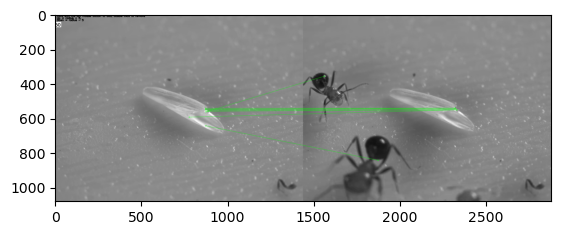

(<matplotlib.image.AxesImage at 0x72e418d77e90>, None)

In [16]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(object_frame,keypoints_obj,img_scene,keypoints_scene,good_matches,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()

In [15]:

#-- Localize the object
obj = np.empty((len(good_matches),2), dtype=np.float32)
scene = np.empty((len(good_matches),2), dtype=np.float32)
for i in range(len(good_matches)):
    #-- Get the keypoints from the good matches
    obj[i,0] = keypoints_obj[good_matches[i].queryIdx].pt[0]
    obj[i,1] = keypoints_obj[good_matches[i].queryIdx].pt[1]
    scene[i,0] = keypoints_scene[good_matches[i].trainIdx].pt[0]
    scene[i,1] = keypoints_scene[good_matches[i].trainIdx].pt[1]
 
H, _ =  cv2.findHomography(obj, scene, cv2.RANSAC)
 
#-- Get the corners from the image_1 ( the object to be "detected" )
obj_corners = np.empty((4,1,2), dtype=np.float32)
obj_corners[0,0,0] = 0
obj_corners[0,0,1] = 0
obj_corners[1,0,0] = object_frame.shape[1]
obj_corners[1,0,1] = 0
obj_corners[2,0,0] = object_frame.shape[1]
obj_corners[2,0,1] = object_frame.shape[0]
obj_corners[3,0,0] = 0
obj_corners[3,0,1] = object_frame.shape[0]
 
scene_corners = cv2.perspectiveTransform(obj_corners, H)
 
#-- Draw lines between the corners (the mapped object in the scene - image_2 )
cv2.line(img_matches, (int(scene_corners[0,0,0] + object_frame.shape[1]), int(scene_corners[0,0,1])),\
    (int(scene_corners[1,0,0] + object_frame.shape[1]), int(scene_corners[1,0,1])), (0,255,0), 4)
cv2.line(img_matches, (int(scene_corners[1,0,0] + object_frame.shape[1]), int(scene_corners[1,0,1])),\
    (int(scene_corners[2,0,0] + object_frame.shape[1]), int(scene_corners[2,0,1])), (0,255,0), 4)
cv2.line(img_matches, (int(scene_corners[2,0,0] + object_frame.shape[1]), int(scene_corners[2,0,1])),\
    (int(scene_corners[3,0,0] + object_frame.shape[1]), int(scene_corners[3,0,1])), (0,255,0), 4)
cv2.line(img_matches, (int(scene_corners[3,0,0] + object_frame.shape[1]), int(scene_corners[3,0,1])),\
    (int(scene_corners[0,0,0] + object_frame.shape[1]), int(scene_corners[0,0,1])), (0,255,0), 4)
 
#-- Show detected matches
cv2.imshow('Good Matches & Object detection', img_matches)
cv2.waitKey()
cap.release()
cv2.destroyAllWindows()

In [114]:
cv2.imshow('Good Matches & Object detection', img_matches)
cv2.waitKey()
cap.release()
cv2.destroyAllWindows()
